#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [165]:
import pandas as pd
pd.set_option('display.max_rows', None)
#pd.set_option('plotting.backend', 'plotly')
pd.set_option('plotting.backend', 'matplotlib')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from datetime import datetime

from scipy import stats as st

In [166]:
# Константы
SAMPLE_SIZE = 200
RS = 12345  # random seed
CRIT_RMSE = 48
ML = 1 # max lag
RMS = 24 # rolling mean size
K1 = 0.5 # поправочный коэффициент для начального значения при восстановлении количеств из разностей
K2 = 0.8 # поправочный коэффициент для всех последующих значений при восстановлении количеств из разностей
K3 = 1.2 # поправочный коэффициент для вычисления нового значения при восстановлении количеств из разностей

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные отсортированы по времени: True
Имеем данные за период: 2018-03-01 00:00:00 - 2018-08-31 23:50:00


<AxesSubplot:title={'center':'Исходные значения'}, xlabel='Время заказа', ylabel='Количество заказов'>

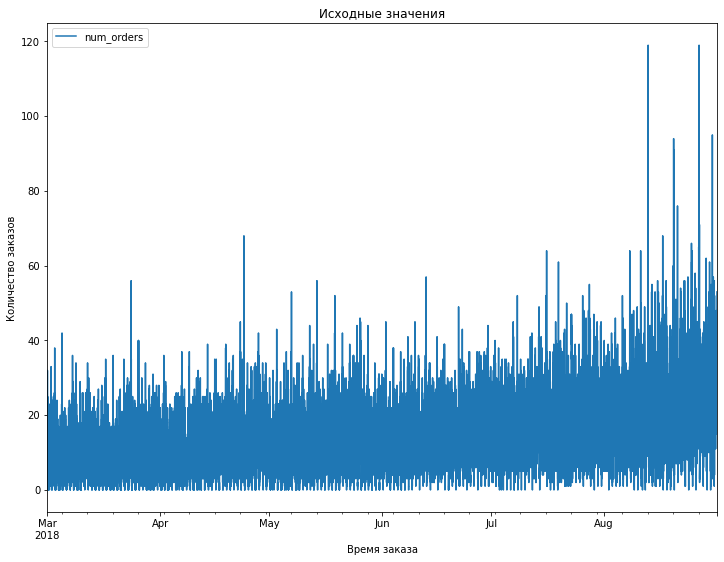

In [167]:
data = pd.read_csv(r'c:\Users\e.yumagulov\datasets\taxi.csv', index_col=[0], parse_dates=[0])
data.info()
display(data.head())
display(data.describe())
data.sort_index(inplace=True)
print('Данные отсортированы по времени:', data.index.is_monotonic)
print('Имеем данные за период:', data.index.min(), '-', data.index.max())
data.plot(figsize=[12,9], title='Исходные значения', xlabel='Время заказа', ylabel='Количество заказов')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:title={'center':'Значения ресемплированные с интервалом в 1 час'}, xlabel='Время заказа', ylabel='Количество заказов'>

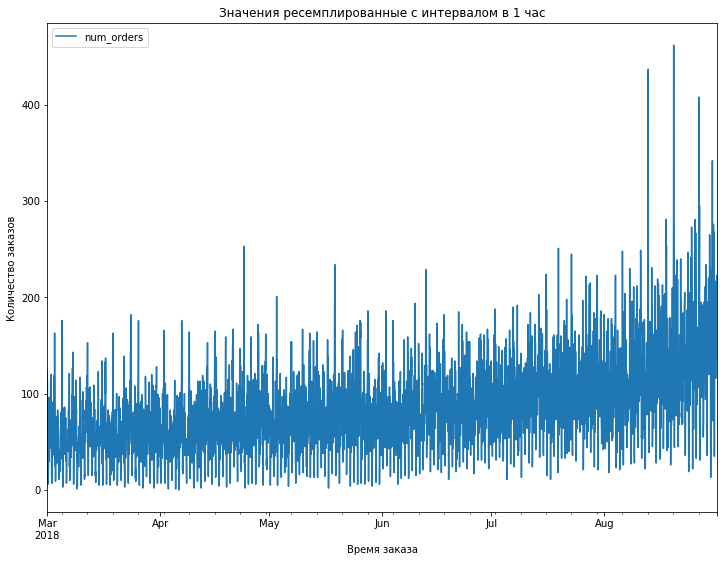

In [168]:
data = data.resample('1H').sum()
#data = data.dropna()
data = data.fillna(data['num_orders'].median())
data.info()
data.plot(figsize=[12,9], title='Значения ресемплированные с интервалом в 1 час', xlabel='Время заказа', ylabel='Количество заказов')

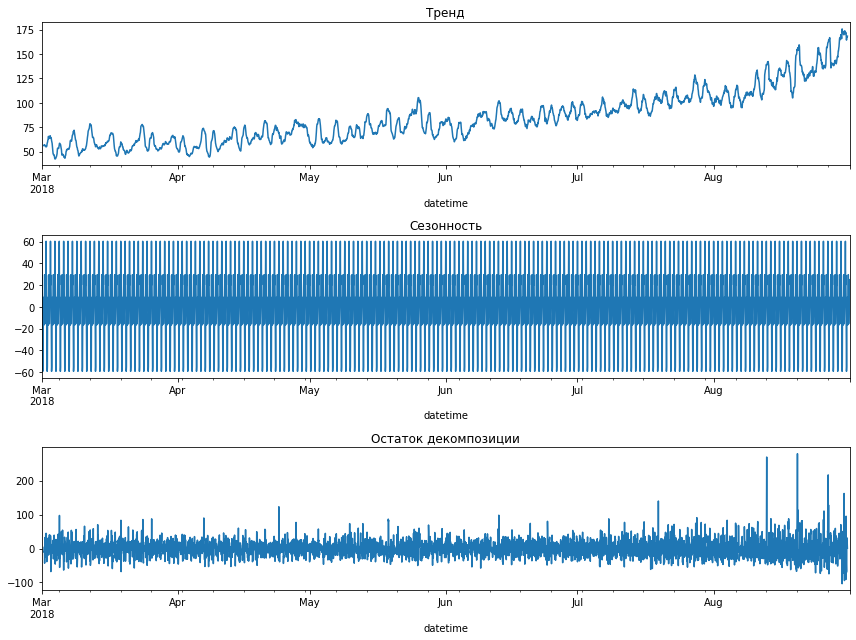

In [169]:
decomposed = seasonal_decompose(data) 
plt.figure(figsize=(12,9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')
plt.tight_layout()
data['trend'] = decomposed.trend
data['seasonal'] = decomposed.seasonal

Text(0.5, 1.0, 'Сезонность за май')

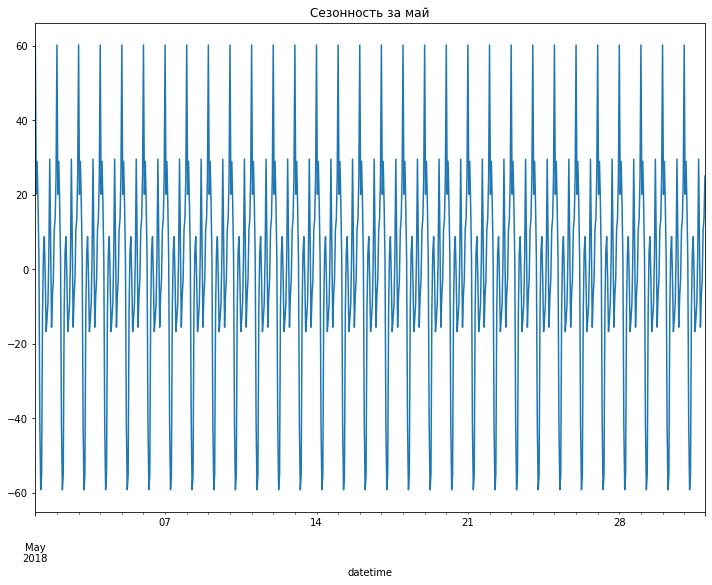

In [170]:
plt.figure(figsize=(12,9))
decomposed.seasonal['2018-05-01':'2018-05-31'].plot(ax=plt.gca()) 
plt.title('Сезонность за май')

## Анализ

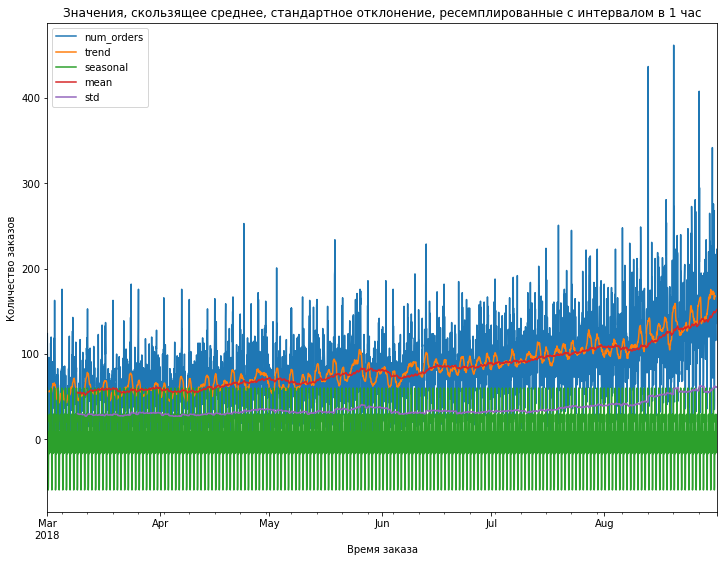

In [171]:
data['mean'] = data['num_orders'].rolling(SAMPLE_SIZE).mean()
data['std'] = data['num_orders'].rolling(SAMPLE_SIZE).std()
data.plot(figsize=[12,9], title='Значения, скользящее среднее, стандартное отклонение, ресемплированные с интервалом в 1 час', xlabel='Время заказа', ylabel='Количество заказов')
data = data.drop(['mean', 'std'], axis=1)

<AxesSubplot:title={'center':'Разности временного ряда, скользящее среднее, стандартное отклонение'}, xlabel='Время заказа', ylabel='Разности'>

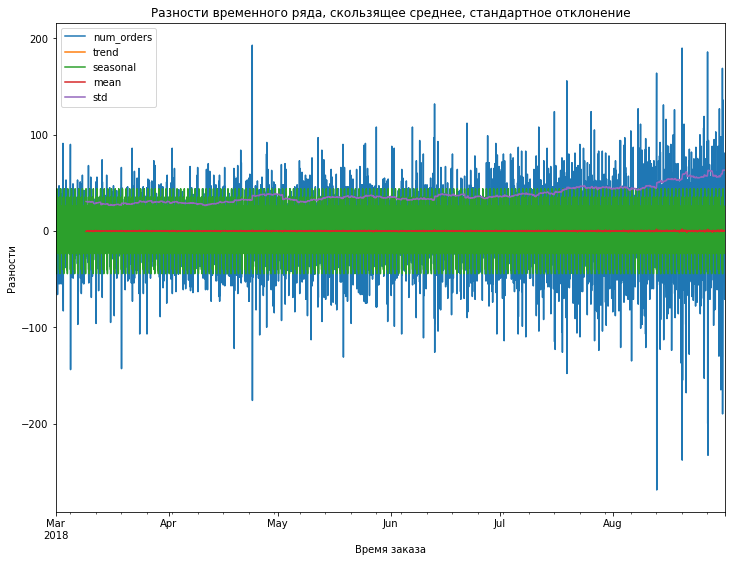

In [172]:
# Берем разностии заменяем ими временной ряд
diff_data = data - data.shift()
diff_data['mean'] = diff_data['num_orders'].rolling(SAMPLE_SIZE).mean()
diff_data['std'] = diff_data['num_orders'].rolling(SAMPLE_SIZE).std()
diff_data.plot(figsize=[12,9], title='Разности временного ряда, скользящее среднее, стандартное отклонение', xlabel='Время заказа', ylabel='Разности')
#diff_data = diff_data.drop(['mean', 'std'], axis=1) # для предсказания разницы эти признаки критичны

## Обучение
* сначала протестируем вариант с предсказанием разностей
* а затем - вариант с предсказанием количеств
### Вариант с разностями (diff_data)

In [173]:
def make_features(dt, max_lag, rolling_mean_size):
    dt['hour'] = dt.index.hour
#    dt['month'] = dt.index.month
#    dt['day'] = dt.index.day
    dt['dayofweek'] = dt.index.dayofweek
    for lag in range(1, max_lag + 1):
        dt['lag_{}'.format(lag)] = dt['num_orders'].shift(lag)
    dt['rolling_mean'] = dt['num_orders'].shift().rolling(rolling_mean_size).mean()
    return dt

diff_data = make_features(diff_data, ML, RMS)

In [174]:
display(diff_data.head())
diff_data = diff_data.dropna()
train, test = train_test_split(diff_data, shuffle=False, test_size=0.1)

print('Размерность обучающей выборки:', train.shape)
print('Размерность тестовой выборки:', test.shape)
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

,num_orders,trend,seasonal,mean,std,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,-40.071038,NaN,NaN,1,3,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,8.805669,NaN,NaN,2,3,-39.0,NaN
2018-03-01 03:00:00,-5.0,NaN,-11.097336,NaN,NaN,3,3,-14.0,NaN
2018-03-01 04:00:00,-23.0,NaN,-15.094262,NaN,NaN,4,3,-5.0,NaN


Размерность обучающей выборки: (3783, 9)
Размерность тестовой выборки: (421, 9)


In [175]:
%%time

model = LinearRegression()
model.fit(train_features, train_target)
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

print("MAE обучающей выборки:", mean_absolute_error(train_target, pred_train))
print("MAE тестовой выборки: ", mean_absolute_error(test_target, pred_test))

rmse = mean_squared_error(test_target, pred_test, sample_weight=None, multioutput='uniform_average', squared=False)
print(f'Метрика RMSE модели LinearRegression на тестовой выборке: {np.round(rmse, 2)}')

MAE обучающей выборки: 18.141735214612414
MAE тестовой выборки:  32.34600472869259
Метрика RMSE модели LinearRegression на тестовой выборке: 41.46
Wall time: 11 ms


In [12]:
%%time

params = {'depth': [4, 6, 8],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,8],
         'iterations': [100, 200]}
cbr = CatBoostRegressor(silent=True, grow_policy='Depthwise')
cbr_model = GridSearchCV(cbr, params, scoring="roc_auc", cv = 3)
cbr_model.fit(train_features, train_target)

print("Лучшие параметры для модели CatBoostRegressor (Depthwise) определенные GridSearchCV:", cbr_model.best_params_)

Лучшие параметры для модели CatBoostRegressor (Depthwise) определенные GridSearchCV: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
Wall time: 1min 42s


### Вариант с количествами (data)

In [176]:
true_data = make_features(data, ML, RMS)
display(true_data.head())
true_data = true_data.dropna()

true_train, true_test = train_test_split(true_data, shuffle=False, test_size=0.1)

confidence_interval = st.t.interval(0.9999, true_train.shape[0]-1, true_train['num_orders'].mean(), true_train['num_orders'].sem())
print('99.99%-ый доверительный интервал:', confidence_interval) # не использовал, т.к. непригодно

print('Размерность обучающей выборки:', true_train.shape)
print('Размерность тестовой выборки:', true_test.shape)
true_train_features = true_train.drop(['num_orders'], axis=1)
true_train_target = true_train['num_orders']
true_test_features = true_test.drop(['num_orders'], axis=1)
true_test_target = true_test['num_orders']

,num_orders,trend,seasonal,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,60.248112,0,3,NaN,NaN
2018-03-01 01:00:00,85,NaN,20.177074,1,3,124.0,NaN
2018-03-01 02:00:00,71,NaN,28.982743,2,3,85.0,NaN
2018-03-01 03:00:00,66,NaN,17.885407,3,3,71.0,NaN
2018-03-01 04:00:00,43,NaN,2.791145,4,3,66.0,NaN


99.99%-ый доверительный интервал: (75.9673685694355, 80.76474710788567)
Размерность обучающей выборки: (3942, 7)
Размерность тестовой выборки: (438, 7)


In [177]:
%%time

model = LinearRegression()
model.fit(true_train_features, true_train_target)
pred_train = model.predict(true_train_features)
pred_test = model.predict(true_test_features)

print("MAE обучающей выборки:", mean_absolute_error(true_train_target, pred_train))
print("MAE тестовой выборки: ", mean_absolute_error(true_test_target, pred_test))

rmse = mean_squared_error(true_test_target, pred_test, sample_weight=None, multioutput='uniform_average', squared=False)
print(f'Метрика RMSE модели LinearRegression на тестовой выборке: {np.round(rmse, 2)}')

MAE обучающей выборки: 16.65194099875178
MAE тестовой выборки:  29.84418578120163
Метрика RMSE модели LinearRegression на тестовой выборке: 40.44
Wall time: 8.99 ms


In [23]:
%%time

params = {'depth': [4, 6, 8, 10, 16],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,8],
         'iterations': [100, 200, 300]}
cbr = CatBoostRegressor(silent=True, grow_policy='Lossguide')
cbr_model = GridSearchCV(cbr, params, scoring="neg_mean_squared_error", cv = 5)
cbr_model.fit(true_train_features, true_train_target)

print("Лучшие параметры для модели CatBoostRegressor (Lossguide) определенные GridSearchCV:", cbr_model.best_params_)

Лучшие параметры для модели CatBoostRegressor (Lossguide) определенные GridSearchCV: {'depth': 16, 'iterations': 100, 'l2_leaf_reg': 8, 'learning_rate': 0.15}
Wall time: 8min 34s


In [16]:
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

grid = GridSearchCV(LGBMRegressor(random_state=RS), params, scoring='r2', cv=5)
grid.fit(true_train_features, true_train_target)

print("Лучшие параметры для модели LGBMRegressor определенные GridSearchCV:", grid.best_params_)

Лучшие параметры для модели LGBMRegressor определенные GridSearchCV: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 28}


## Тестирование
* сначала протестируем вариант с предсказанием разностей
* а затем - вариант с предсказанием количеств
### Вариант с разностями (diff_data)

In [178]:
%%time

models = [LinearRegression(),          
          Ridge(random_state=RS, solver='auto', max_iter=15000, fit_intercept=True, normalize=False),
          ElasticNet(),
          Lasso(random_state=RS, max_iter=1000),
          DecisionTreeRegressor(random_state=RS, max_depth=6),
          RandomForestRegressor(random_state=RS, n_estimators=80, max_depth=6),
          XGBRegressor(),
          CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=1, learning_rate=0.03, bootstrap_type='MVS', depth=4, grow_policy='Depthwise', iterations=100, silent=True, random_seed=RS),
          LGBMRegressor(objective="regression_l2", n_estimators=50, random_state=RS),
          DummyRegressor(strategy="median")]

results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(train_features, train_target)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    pred = md.predict(test_features)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    md_rmse = np.round(mean_squared_error(test_target, pred, sample_weight=None, multioutput='uniform_average', squared=False), 2)
    md_r2 = np.round(r2_score(test_target, pred), 3)
    print('-- RMSE:', md_rmse)
    print('-- R2:', md_r2)
    results.append({'Модель': md.__class__.__name__, 
                    'RMSE': md_rmse,
                    'R2': md_r2,
                    'Время_обучения': dt1,
                    'Время_предсказания': dt2,                    
                    'Гиперпараметры': md.get_params(deep=False),
                    'Модель_пригодна': md_rmse<=CRIT_RMSE,
                    'pred': pred}) 
    print('')
              
results = pd.DataFrame(results)
display(results.drop('pred', axis=1))

Идут вычисления по модели LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
-- модель обучена
-- получены предсказания
-- RMSE: 41.46
-- R2: 0.515

Идут вычисления по модели Ridge: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 15000, 'normalize': False, 'random_state': 12345, 'solver': 'auto', 'tol': 0.001}
-- модель обучена
-- получены предсказания
-- RMSE: 41.46
-- R2: 0.515

Идут вычисления по модели ElasticNet: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- RMSE: 45.64
-- R2: 0.412

Идут вычисления по модели Lasso: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 12345, 'selecti

,Модель,RMSE,R2,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LinearRegression,41.46,0.515,0.0s,0.0s,"{'copy_X': True, 'fit_intercept': True, 'n_job...",True
1,Ridge,41.46,0.515,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
2,ElasticNet,45.64,0.412,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
3,Lasso,42.21,0.497,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
4,DecisionTreeRegressor,39.78,0.554,0.01s,0.0s,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",True
5,RandomForestRegressor,36.56,0.623,0.56s,0.01s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",True
6,XGBRegressor,35.10,0.653,0.27s,0.0s,"{'objective': 'reg:squarederror', 'base_score'...",True
7,CatBoostRegressor,38.23,0.588,0.22s,0.0s,"{'iterations': 100, 'learning_rate': 0.03, 'de...",True
8,LGBMRegressor,35.49,0.645,0.04s,0.0s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
9,DummyRegressor,59.55,-0.000,0.0s,0.0s,"{'constant': None, 'quantile': None, 'strategy...",False


Wall time: 1.19 s


Сравнение данных по результату предсказания модели LinearRegression:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,25.858109,77.858109,56.141891
2018-08-14 00:00:00,139,40.542473,123.394752,15.605248
2018-08-14 01:00:00,231,-5.593998,111.746164,119.253836
2018-08-14 02:00:00,108,11.483759,121.056828,-13.056828
2018-08-14 03:00:00,190,157.767958,305.536105,-115.536105


Сравнение данных по результату предсказания модели Ridge:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,25.883377,77.883377,56.116623
2018-08-14 00:00:00,139,40.552093,123.430554,15.569446
2018-08-14 01:00:00,231,-5.733452,111.613189,119.386811
2018-08-14 02:00:00,108,11.412659,120.843852,-12.843852
2018-08-14 03:00:00,190,157.564867,305.087939,-115.087939


Сравнение данных по результату предсказания модели ElasticNet:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,30.197925,82.197925,51.802075
2018-08-14 00:00:00,139,37.142046,123.480463,15.519537
2018-08-14 01:00:00,231,-35.439999,76.013245,154.986755
2018-08-14 02:00:00,108,-7.628710,63.818264,44.181736
2018-08-14 03:00:00,190,95.360589,175.698240,14.301760


Сравнение данных по результату предсказания модели Lasso:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,28.038329,80.038329,53.961671
2018-08-14 00:00:00,139,38.969237,123.599880,15.400120
2018-08-14 01:00:00,231,-16.424732,98.946207,132.053793
2018-08-14 02:00:00,108,5.137707,101.153608,6.846392
2018-08-14 03:00:00,190,135.359245,259.538557,-69.538557


Сравнение данных по результату предсказания модели DecisionTreeRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,12.774295,64.774295,69.225705
2018-08-14 00:00:00,139,19.226667,85.255323,53.744677
2018-08-14 01:00:00,231,113.000000,217.445110,13.554890
2018-08-14 02:00:00,108,29.666667,244.347306,-136.347306
2018-08-14 03:00:00,190,108.000000,364.173413,-174.173413


Сравнение данных по результату предсказания модели RandomForestRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,13.113140,65.113140,68.886860
2018-08-14 00:00:00,139,23.049633,90.168174,48.831826
2018-08-14 01:00:00,231,37.205847,131.208464,99.791536
2018-08-14 02:00:00,108,22.288139,152.705893,-44.705893
2018-08-14 03:00:00,190,57.081386,215.095321,-25.095321


Сравнение данных по результату предсказания модели XGBRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,28.236952,80.236952,53.763048
2018-08-14 00:00:00,139,58.585678,147.330287,-8.330287
2018-08-14 01:00:00,231,39.345592,188.651787,42.348213
2018-08-14 02:00:00,108,-3.054834,177.439915,-69.439915
2018-08-14 03:00:00,190,44.587109,223.846849,-33.846849


Сравнение данных по результату предсказания модели CatBoostRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,13.432919,65.432919,68.567081
2018-08-14 00:00:00,139,17.821072,84.200889,54.799111
2018-08-14 01:00:00,231,37.089242,125.339943,105.660057
2018-08-14 02:00:00,108,9.654936,131.912269,-23.912269
2018-08-14 03:00:00,190,56.678807,194.650347,-4.650347


Сравнение данных по результату предсказания модели LGBMRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 23:00:00,134,18.313331,70.313331,63.686669
2018-08-14 00:00:00,139,32.329306,106.295965,32.704035
2018-08-14 01:00:00,231,40.269292,150.367276,80.632724
2018-08-14 02:00:00,108,8.758964,154.863342,-46.863342
2018-08-14 03:00:00,190,63.255443,224.575340,-34.575340


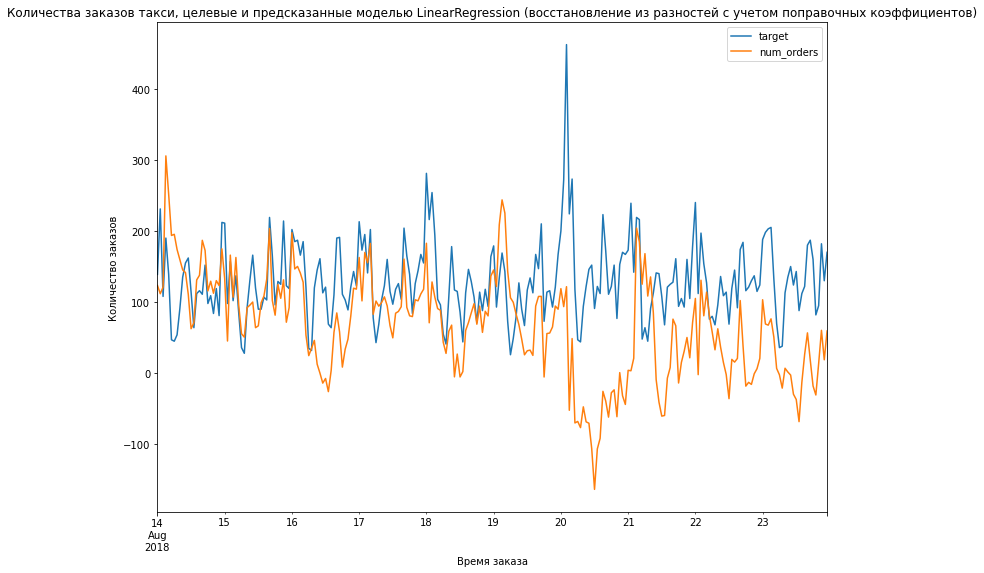

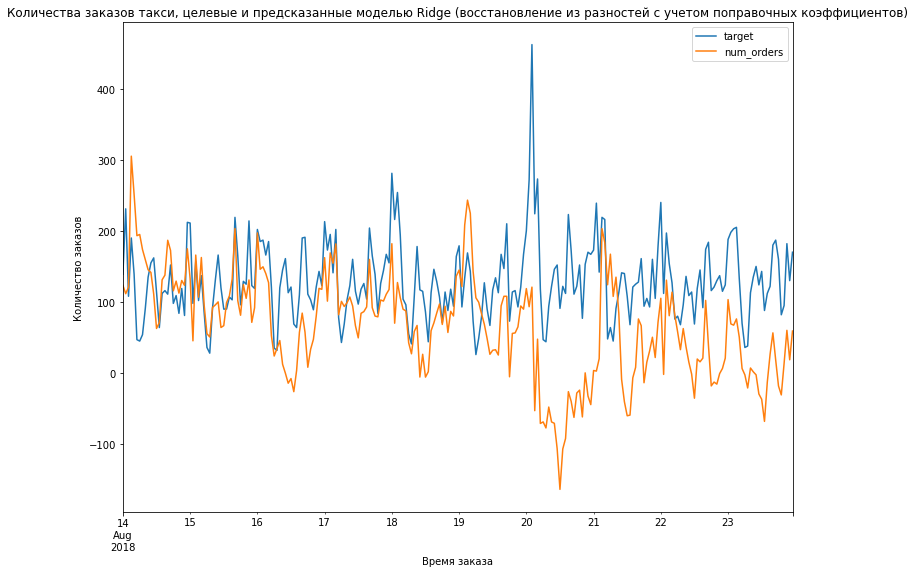

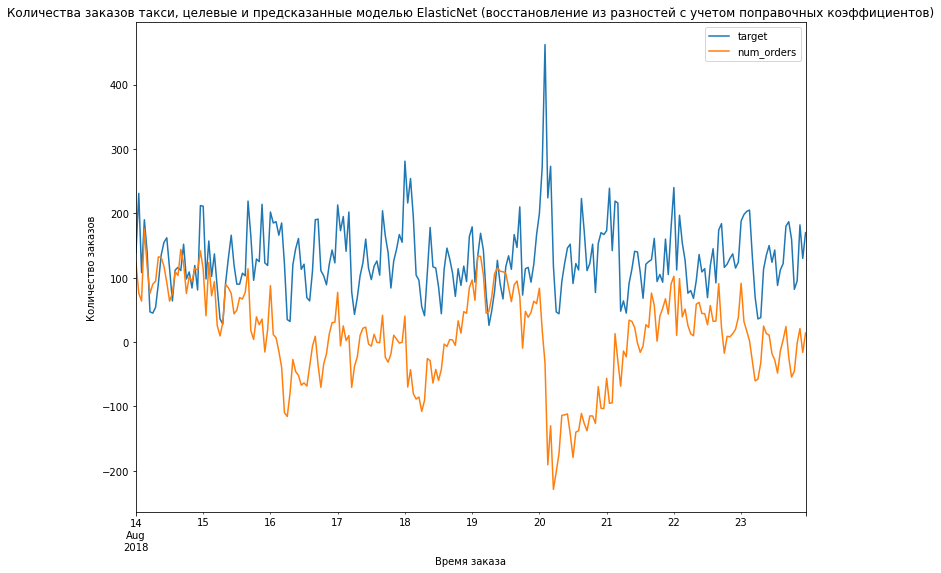

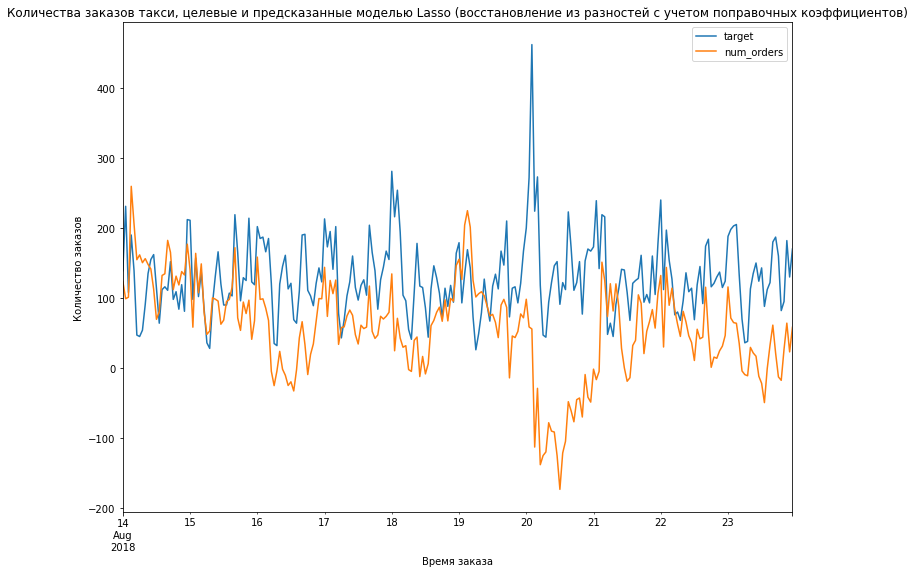

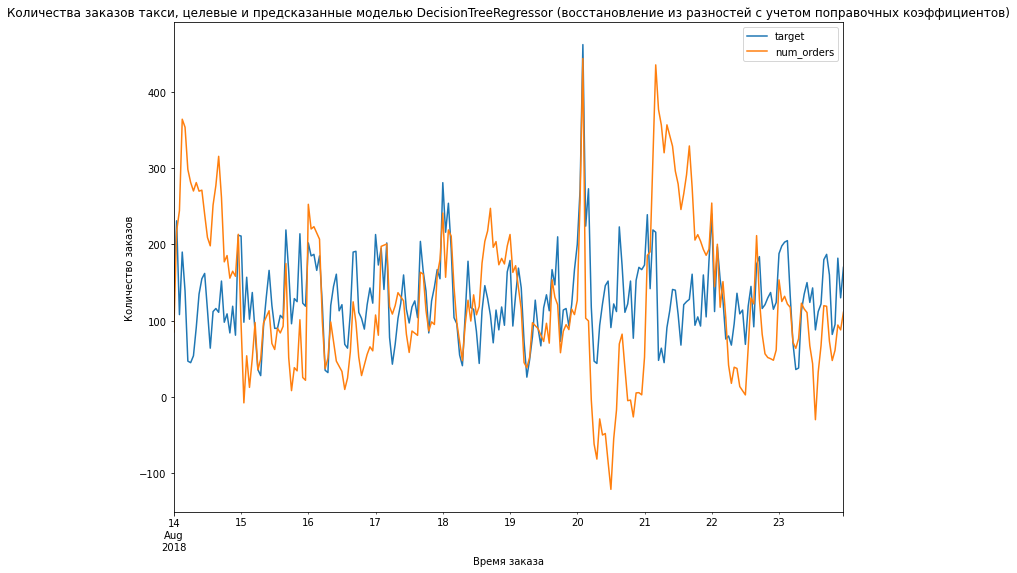

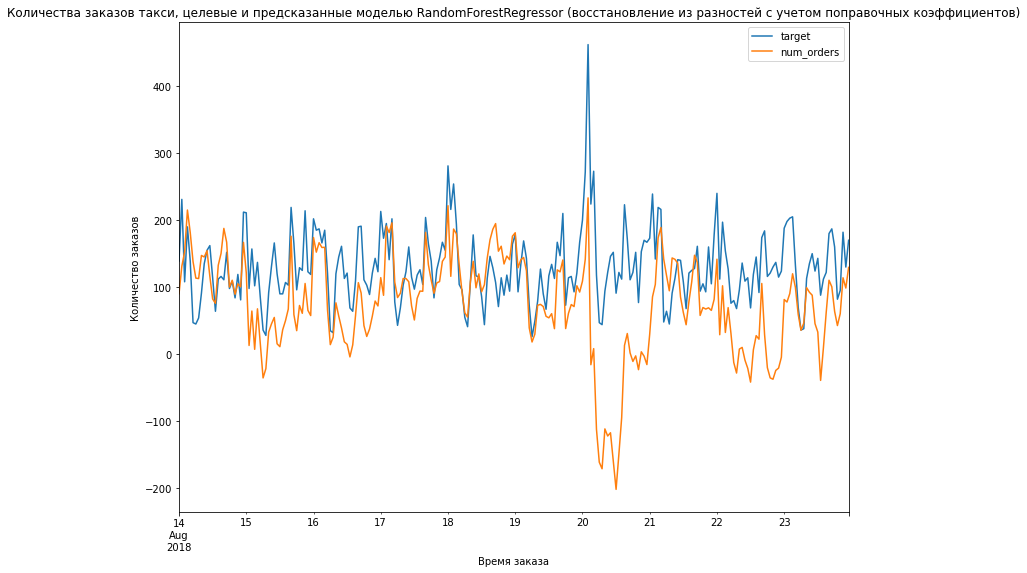

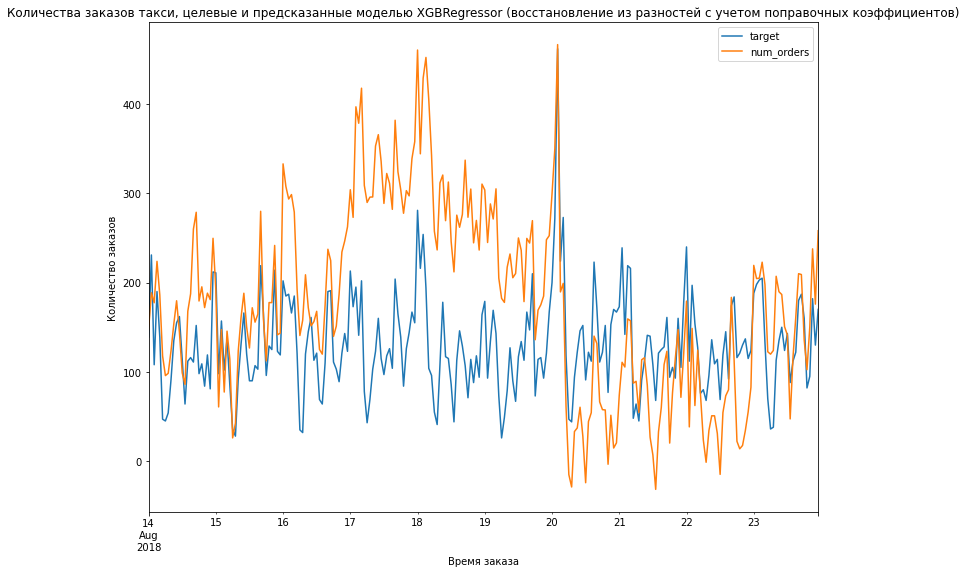

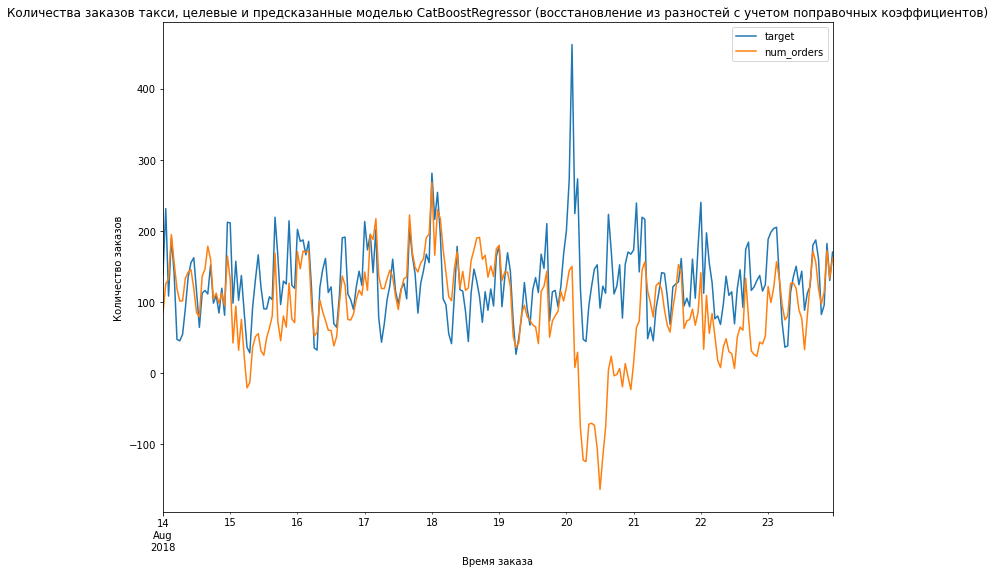

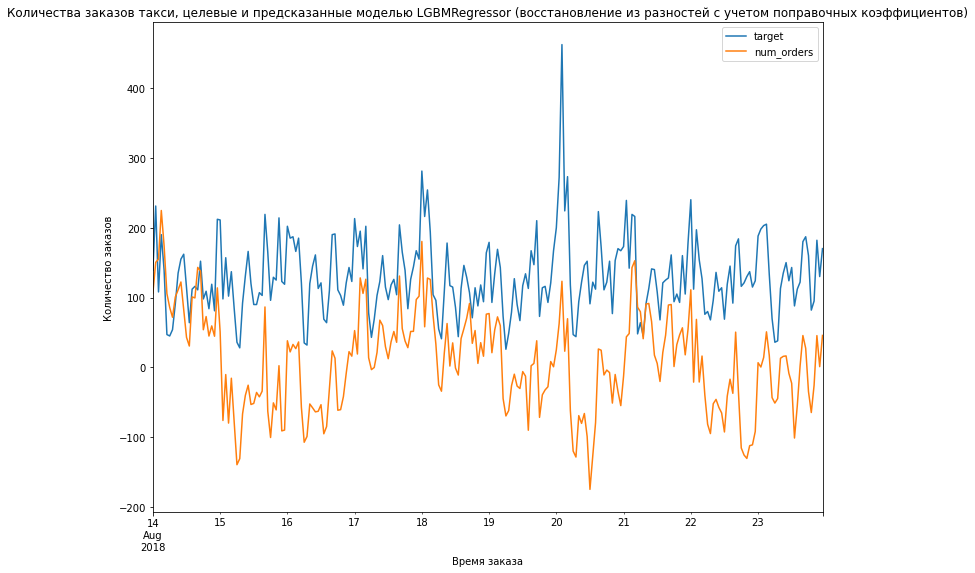

In [179]:
last_num = data.loc[train_target.index[train_target.shape[0]-1],'num_orders'] # берем из исходных данных последнее значение с индексом как в обучающей выборке   

from_test_target = data.loc[test_target.index, 'num_orders'] # берем из исходных данных значения с индексами как в тестовой выборке

model_list = results.query('Модель_пригодна==True')['Модель'].tolist()
for md in model_list:
# Создаем временный датафрейм для сравнения целевых и предсказанных значений
    diff_test_target = pd.DataFrame()
    diff_test_target['target'] = from_test_target
    pred = results.query('Модель==@md').reset_index(drop=True) # чтобы искомый элемент остался с нулевым индексом
    pred = pred.loc[0, 'pred']
    diff_test_target['pred'] = pred
    
# Возвращаемся из разностей к исходным значениям    
    diff_test_target['num_orders'] = 0 # создаем столбец где будут храниться восстановленные значения заказов из разностей
    for i in range(test_target.shape[0]):
        ind = diff_test_target.index[i]
        if i==0:
            diff_test_target.loc[ind, 'num_orders'] = diff_test_target.loc[ind, 'pred'] + last_num * K1 # первое значение берем из предсказания и последнегозначения
        else:
            diff_test_target.loc[ind, 'num_orders'] = K3 * (diff_test_target.loc[ind, 'pred'] + diff_test_target.loc[diff_test_target.index[i-1], 'num_orders'] * K2) # добавляем предсказанную разницу к предыдущему значению

# Выводим результаты
    diff_test_target['2018-08-14':'2018-08-23'].drop('pred', axis=1).plot(figsize=[12,9], title='Количества заказов такси, целевые и предсказанные моделью {} (восстановление из разностей с учетом поправочных коэффициентов)'.format(md), xlabel='Время заказа', ylabel='Количество заказов')
    diff_test_target['error'] = diff_test_target['target'] - diff_test_target['num_orders']
    print('Сравнение данных по результату предсказания модели {}:'.format(md))
    display(diff_test_target.head())

### Вариант с количествами (data)

In [180]:
%%time

models = [LinearRegression(),          
          Ridge(random_state=RS, solver='auto', max_iter=15000, fit_intercept=True, normalize=False),
          ElasticNet(),
          Lasso(random_state=RS, max_iter=1000),
          DecisionTreeRegressor(random_state=RS, max_depth=8),
          RandomForestRegressor(random_state=RS, n_estimators=200, max_depth=16),
          XGBRegressor(),
          CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=8, learning_rate=0.15, bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=100, silent=True, random_seed=RS),
          LGBMRegressor(objective="regression_l2", n_estimators=100, random_state=RS),
          DummyRegressor(strategy="median")]

true_results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(true_train_features, true_train_target)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    pred = md.predict(true_test_features)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    md_rmse = np.round(mean_squared_error(true_test_target, pred, sample_weight=None, multioutput='uniform_average', squared=False), 2)
    md_r2 = np.round(r2_score(true_test_target, pred), 3)
    print('-- RMSE:', md_rmse)
    print('-- R2:', md_r2)
    true_results.append({'Модель': md.__class__.__name__, 
                         'RMSE': md_rmse,
                         'R2': md_r2,
                         'Время_обучения': dt1,
                         'Время_предсказания': dt2,                    
                         'Гиперпараметры': md.get_params(deep=False),
                         'Модель_пригодна': md_rmse<=CRIT_RMSE,
                         'pred': pred}) 
    print('')
              
true_results = pd.DataFrame(true_results)
display(true_results.drop('pred', axis=1))
delta_results = true_results.drop(['Время_обучения', 'Время_предсказания', 'Гиперпараметры', 'Модель_пригодна', 'pred'], axis=1)
delta_results['RMSE_diff'] = results['RMSE']
delta_results['R2_diff'] = results['R2']
display(delta_results)

Идут вычисления по модели LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
-- модель обучена
-- получены предсказания
-- RMSE: 40.44
-- R2: 0.525

Идут вычисления по модели Ridge: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 15000, 'normalize': False, 'random_state': 12345, 'solver': 'auto', 'tol': 0.001}
-- модель обучена
-- получены предсказания
-- RMSE: 40.44
-- R2: 0.525

Идут вычисления по модели ElasticNet: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- RMSE: 40.45
-- R2: 0.525

Идут вычисления по модели Lasso: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 12345, 'selecti

,Модель,RMSE,R2,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LinearRegression,40.44,0.525,0.0s,0.0s,"{'copy_X': True, 'fit_intercept': True, 'n_job...",True
1,Ridge,40.44,0.525,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
2,ElasticNet,40.45,0.525,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
3,Lasso,40.46,0.525,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",True
4,DecisionTreeRegressor,43.75,0.444,0.01s,0.0s,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",True
5,RandomForestRegressor,38.45,0.571,2.42s,0.03s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",True
6,XGBRegressor,46.54,0.371,0.21s,0.0s,"{'objective': 'reg:squarederror', 'base_score'...",True
7,CatBoostRegressor,41.37,0.503,0.5s,0.0s,"{'iterations': 100, 'learning_rate': 0.15, 'de...",True
8,LGBMRegressor,38.92,0.560,0.06s,0.0s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
9,DummyRegressor,86.15,-1.156,0.0s,0.0s,"{'constant': None, 'quantile': None, 'strategy...",False


,Модель,RMSE,R2,RMSE_diff,R2_diff
0,LinearRegression,40.44,0.525,41.46,0.515
1,Ridge,40.44,0.525,41.46,0.515
2,ElasticNet,40.45,0.525,45.64,0.412
3,Lasso,40.46,0.525,42.21,0.497
4,DecisionTreeRegressor,43.75,0.444,39.78,0.554
5,RandomForestRegressor,38.45,0.571,36.56,0.623
6,XGBRegressor,46.54,0.371,35.10,0.653
7,CatBoostRegressor,41.37,0.503,38.23,0.588
8,LGBMRegressor,38.92,0.560,35.49,0.645
9,DummyRegressor,86.15,-1.156,59.55,-0.000


Wall time: 3.31 s


Сравнение данных по результату предсказания модели LinearRegression:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,89.735661,-23.735661
2018-08-13 07:00:00,39,93.468800,-54.468800
2018-08-13 08:00:00,91,132.519635,-41.519635
2018-08-13 09:00:00,137,148.678661,-11.678661
2018-08-13 10:00:00,156,153.945189,2.054811


Сравнение данных по результату предсказания модели Ridge:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,89.735486,-23.735486
2018-08-13 07:00:00,39,93.468617,-54.468617
2018-08-13 08:00:00,91,132.519407,-41.519407
2018-08-13 09:00:00,137,148.678452,-11.678452
2018-08-13 10:00:00,156,153.945012,2.054988


Сравнение данных по результату предсказания модели ElasticNet:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,88.982368,-22.982368
2018-08-13 07:00:00,39,92.698970,-53.698970
2018-08-13 08:00:00,91,131.613398,-40.613398
2018-08-13 09:00:00,137,147.795601,-10.795601
2018-08-13 10:00:00,156,153.145645,2.854355


Сравнение данных по результату предсказания модели Lasso:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,88.761611,-22.761611
2018-08-13 07:00:00,39,92.490383,-53.490383
2018-08-13 08:00:00,91,131.438545,-40.438545
2018-08-13 09:00:00,137,147.576219,-10.576219
2018-08-13 10:00:00,156,152.890045,3.109955


Сравнение данных по результату предсказания модели DecisionTreeRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,38.250000,27.750000
2018-08-13 07:00:00,39,38.250000,0.750000
2018-08-13 08:00:00,91,91.966667,-0.966667
2018-08-13 09:00:00,137,134.307692,2.692308
2018-08-13 10:00:00,156,134.307692,21.692308


Сравнение данных по результату предсказания модели RandomForestRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,38.210000,27.790000
2018-08-13 07:00:00,39,38.960000,0.040000
2018-08-13 08:00:00,91,92.702421,-1.702421
2018-08-13 09:00:00,137,144.992881,-7.992881
2018-08-13 10:00:00,156,158.469286,-2.469286


Сравнение данных по результату предсказания модели XGBRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,39.804031,26.195969
2018-08-13 07:00:00,39,32.043091,6.956909
2018-08-13 08:00:00,91,79.759148,11.240852
2018-08-13 09:00:00,137,133.589706,3.410294
2018-08-13 10:00:00,156,162.379364,-6.379364


Сравнение данных по результату предсказания модели CatBoostRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,45.760341,20.239659
2018-08-13 07:00:00,39,51.703718,-12.703718
2018-08-13 08:00:00,91,92.707866,-1.707866
2018-08-13 09:00:00,137,129.974306,7.025694
2018-08-13 10:00:00,156,152.682470,3.317530


Сравнение данных по результату предсказания модели LGBMRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,48.323765,17.676235
2018-08-13 07:00:00,39,43.608093,-4.608093
2018-08-13 08:00:00,91,91.165949,-0.165949
2018-08-13 09:00:00,137,135.560501,1.439499
2018-08-13 10:00:00,156,152.720807,3.279193


Сравнение данных по результату предсказания модели DummyRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 06:00:00,66,75.0,-9.0
2018-08-13 07:00:00,39,75.0,-36.0
2018-08-13 08:00:00,91,75.0,16.0
2018-08-13 09:00:00,137,75.0,62.0
2018-08-13 10:00:00,156,75.0,81.0


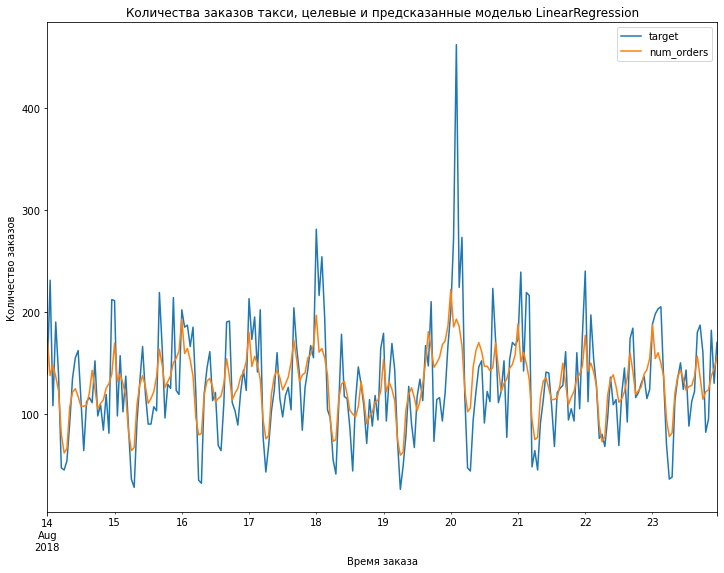

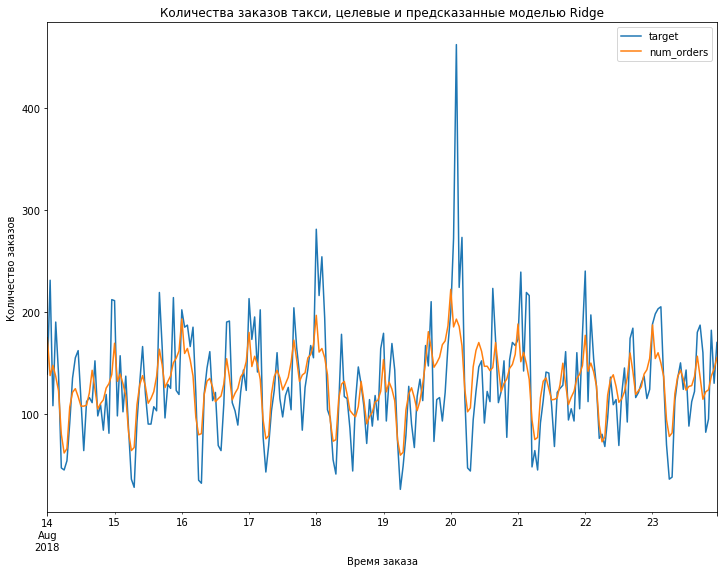

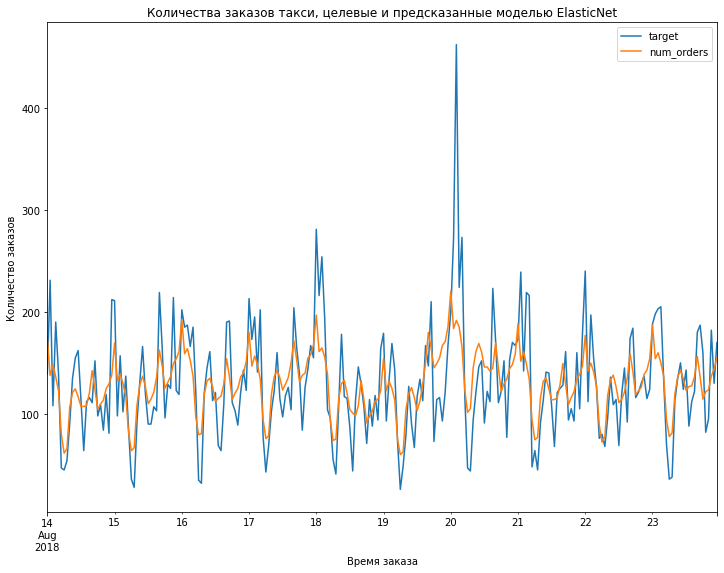

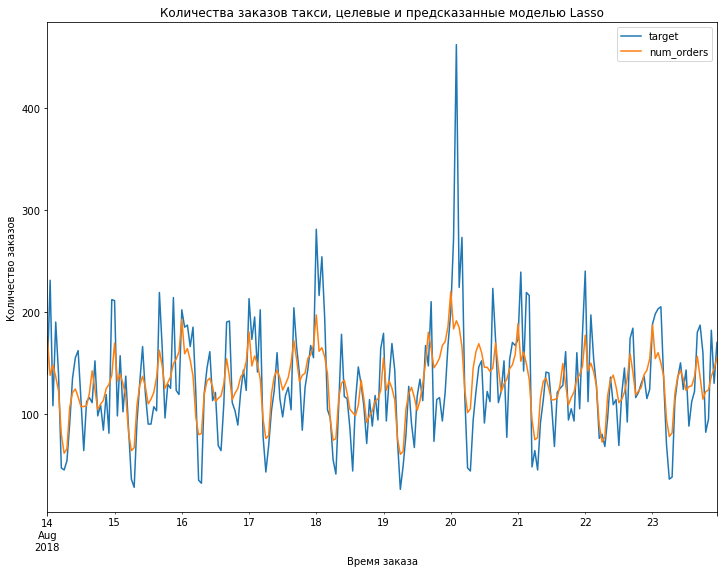

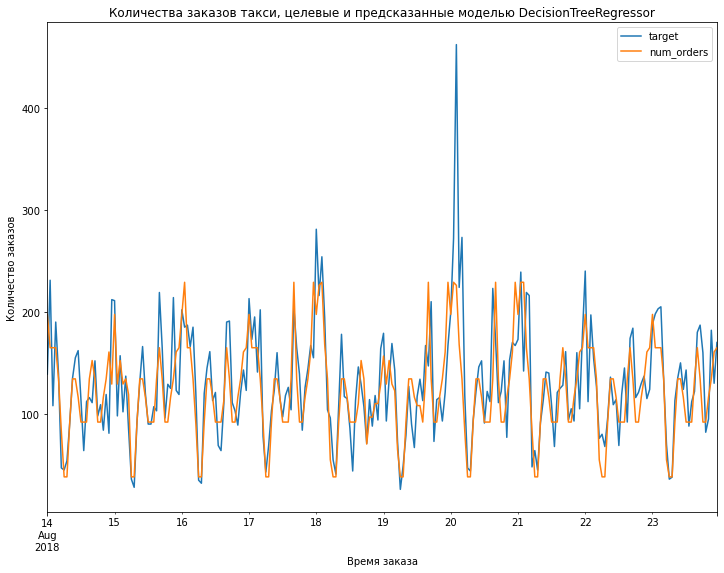

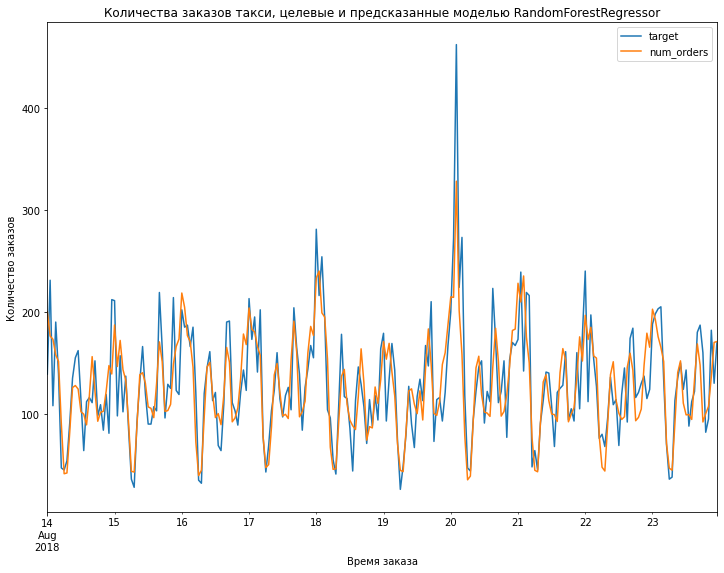

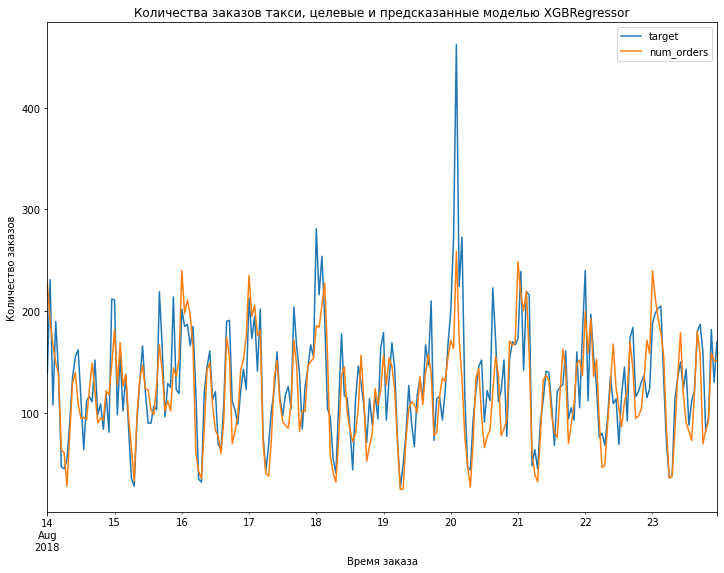

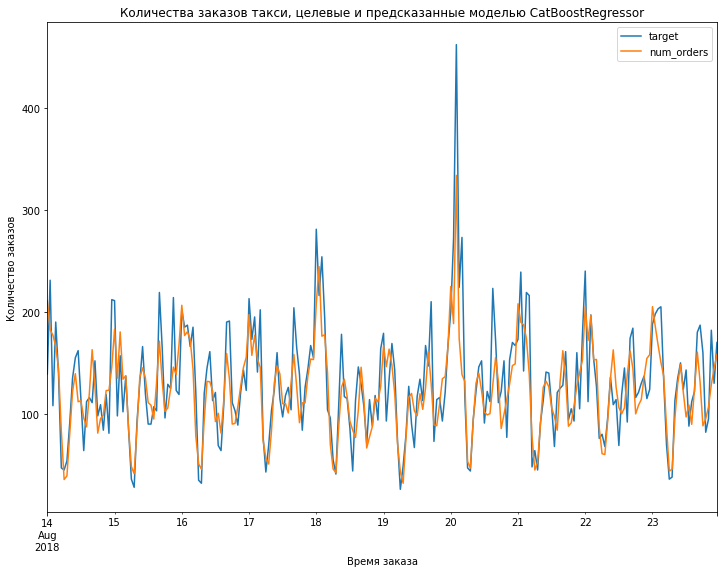

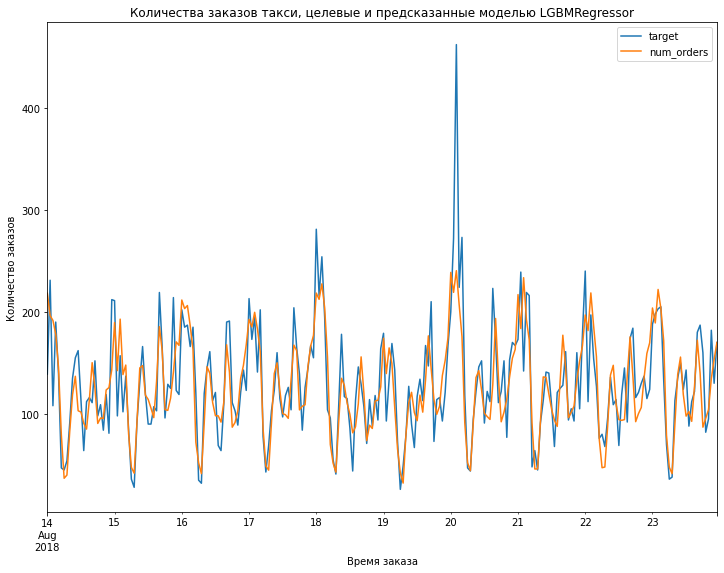

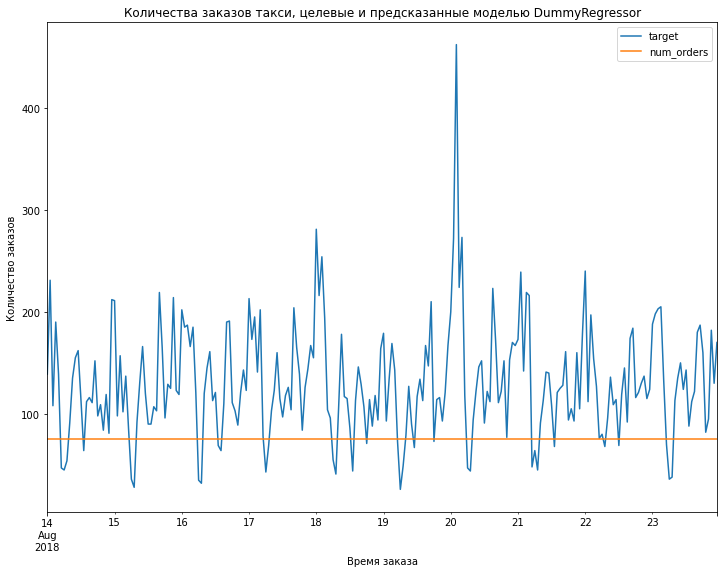

In [181]:
from_test_target = data.loc[true_test_target.index, 'num_orders'] # берем из исходных данных значения с индексами как в тестовой выборке

model_list = true_results['Модель'].tolist() # не сортировал по пригодности чтобы показать наличие сдвига у моделей линиейной регрессии
for md in model_list:
# Создаем временный датафрейм для сравнения целевых и предсказанных значений
    diff_test_target = pd.DataFrame()
    diff_test_target['target'] = from_test_target
    pred = true_results.query('Модель==@md').reset_index(drop=True) # чтобы искомый элемент остался с нулевым индексом
    pred = pred.loc[0, 'pred']
    diff_test_target['num_orders'] = pred

# Выводим результаты
    diff_test_target['2018-08-14':'2018-08-23'].plot(figsize=[12,9], title='Количества заказов такси, целевые и предсказанные моделью {}'.format(md), xlabel='Время заказа', ylabel='Количество заказов')
    diff_test_target['error'] = diff_test_target['target'] - diff_test_target['num_orders']
    print('Сравнение данных по результату предсказания модели {}:'.format(md))
    display(diff_test_target.head())

## Выводы:
1. Восстановление количеств из предсказаний разницы (вне зависимости от показаний метрики) приводит к очень плохому результату (большая ошибка). Несмотря на то, что временной ряд разниц более стационарен, предсказывать нужно именно количества напрямую.
2. Несмотря на более лучшие значения метрик предсказаний разницы, конечный результат получается значительно хуже. Его можно немного выправить при помощи поправочных коэффициентов, но это - "костыль".
3. Предсказания количеств в моделях линейной регрессии опаздывают по времени по сравнению с целевым признаком, а в моделях градиентного бустинга этой ошибки нет.
4. При заданных гиперпараметрах, при предсказнии количеств <s>наилучшая метрика RMSE=40.98 получилась для модели LGBMRegressor (она же имеет малое время обучения)</s> получилась для модели RandomForestRegressor c RMSE=38.45!
5. Качество предсказания даже у самой лучшей модели довольно низкое (R2=0.510), но в заданный порог RMSE<=48 укладываются многие из моделей: RandomForestRegressor, XGBRegressor, CatBoostRegressor, LGBMRegressor
6. RandomForestRegressor и DecisionTreeRegressor сглаживают многие всплески (у моделей линейной регрессии такойошибки нет), из-за чего идут ошибки предсказания.
7. Поэкспериментировал с признаками - если добавить в признаки тренд и сезонность, то RMSE линейной регрессии внезапно улучшается с неприемлемого до 40! У градиентного бустинга качество тоже улучшается, но незначительно (до 39) а вот качество RandomForestRegressor наоборот дико падает с довольно хорошего до неприемлемого. Пробовал поотсекать обучающие данные в 99.99% доверительном интервале - все сильно ухудшилось.
8. RandomForestRegressor починился удалением mean и std из признаков - остальные либо не изменились, либо стали чуть лучше. Тут другой вопрос - в реальной задаче у нас будут только время, остальные признаки нам неоткуда будет брать и модель использующая лаги, скользящие окна и декомпозицю по сути непригодна получается.